# Métodos Lineares: Regressão - Aula 2

In [1]:
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Configura o estilo e tamanho dos gráficos.

sns.set_style("whitegrid")
sns.set_palette("Purples_r")
plt.rcParams.update({
    'font.size': 14,
    'figure.figsize': (12, 8)
})

## Carrega dados e exibe informações básicas

O dataset de imóveis fica armazenado na variável `imoveis_df`. É o mesmo que usamos na aula passada.

In [3]:
imoveis_df = pd.read_csv("https://raw.githubusercontent.com/nubank/diversidados-curso-ds/master/iniciante/LinReg/dataset_imoveis.csv")
print(imoveis_df.shape)
print(imoveis_df.columns)
imoveis_df.head()

(21613, 17)
Index(['id', 'data', 'preco_dolares', 'quartos', 'banheiros', 'area_util_m2',
       'area_total_m2', 'andares', 'orla_mar', 'nota_vista', 'nota_condicao',
       'nota', 'area_porao_m2', 'ano_construcao', 'ano_reforma', 'tem_porao',
       'teve_reforma'],
      dtype='object')


,id,data,preco_dolares,quartos,banheiros,area_util_m2,area_total_m2,andares,orla_mar,nota_vista,nota_condicao,nota,area_porao_m2,ano_construcao,ano_reforma,tem_porao,teve_reforma
0,7129300520,2014-10-13,221900,3,1,109.625587,524.902176,1.0,0,0,3,7,0.000000,1955,0,0,0
1,6414100192,2014-12-09,538000,3,3,238.760813,672.803816,2.0,0,0,3,7,37.161216,1951,1991,1,1
2,5631500400,2015-02-25,180000,2,1,71.535341,929.030400,1.0,0,0,3,6,0.000000,1933,0,0,0
3,2487200875,2014-12-09,604000,4,3,182.089958,464.515200,1.0,0,0,5,7,84.541766,1965,0,1,0
4,1954400510,2015-02-18,510000,3,2,156.077107,750.656563,1.0,0,0,3,8,0.000000,1987,0,0,0


## Gerando gráficos com o dataset de imóveis

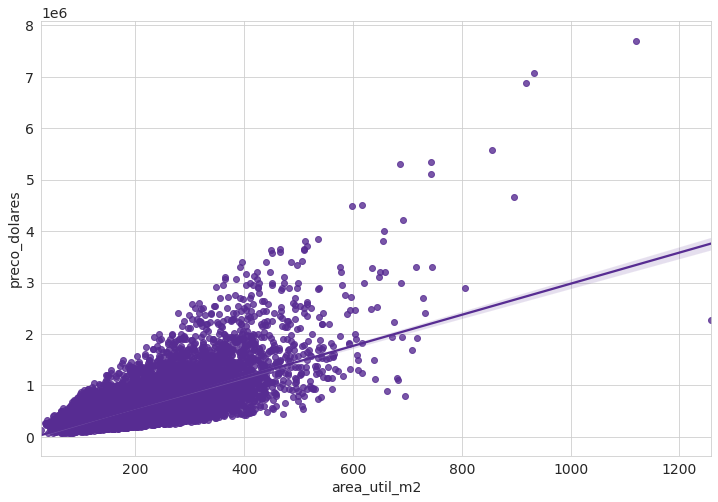

In [4]:
sns.regplot(x='area_util_m2', y='preco_dolares', data=imoveis_df)

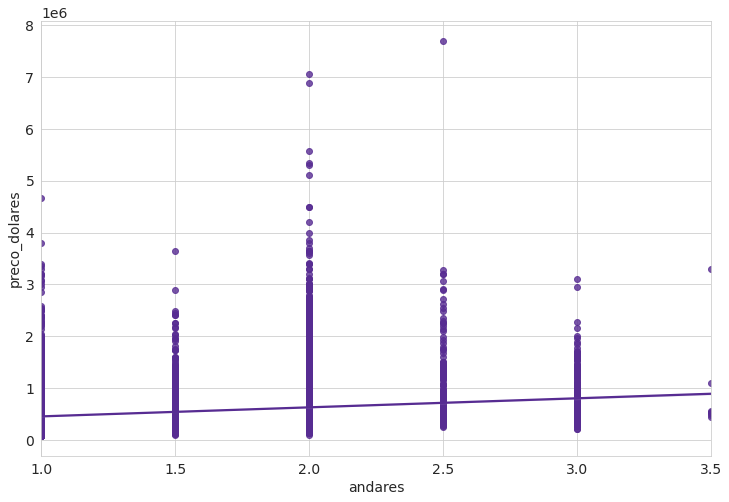

In [5]:
sns.regplot(x='andares', y='preco_dolares', data=imoveis_df)

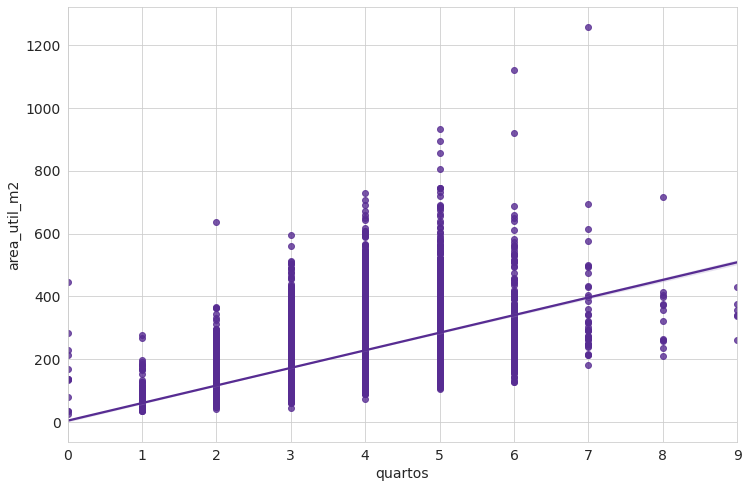

In [6]:
sns.regplot(x='quartos', y='area_util_m2', data=imoveis_df.loc[imoveis_df['quartos'] < 10])

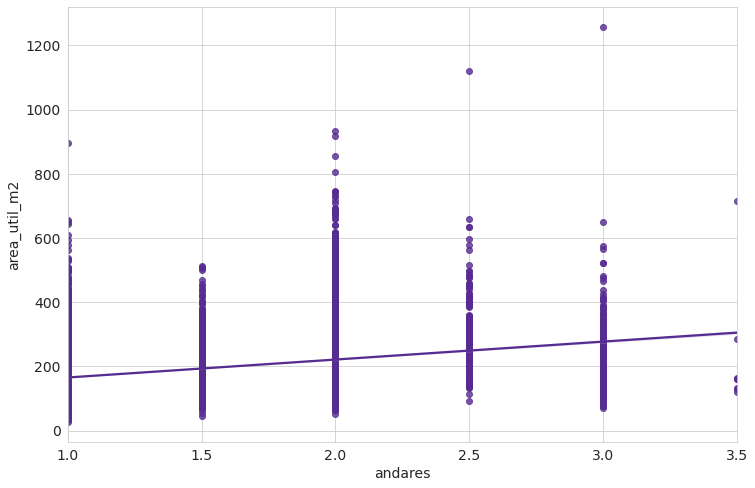

In [7]:
sns.regplot(x='andares', y='area_util_m2', data=imoveis_df)

## Criando dataset sintético de apartamentos

Esse dataset será criado usando funções sintéticas para fins educativos, e não representa necessariamente a realidade. Ele ficará armazenado na variável `apartamentos_df`.

Você não precisa entender como exatamente geramos esse dataset, ou que distribuições são essas, mas talvez seja interessante olhar como definimos que preço é uma função de todas as outras variáveis.

```
preco = area_util_m2 * ...
```

In [8]:
def gerar_apartamentos_df(n):
    def preco_idade(x):
        if x < 5:
            return 0
        elif x < 15:
            return 1000
        elif x < 30:
            return 5000
        else:
            return 10000

    def preco_andar(x):
        if x < 5:
            return 0
        elif x < 12:
            return 100000
        else:
            return 300000

    def preco_bairro(x):
        if x in [1, 7]:
            return 850
        elif x in [2, 5]:
            return 350
        elif x == 6:
            return -100
        else:
            return -600

    np.random.seed(42)
    df = pd.DataFrame()

    area_util_m2 = np.maximum(np.ones(n) * 25, 25 + np.random.beta(2.5, 100, n) * 2300)
    quartos = np.round(np.maximum(np.ones(n), area_util_m2 / 35 + np.random.normal(0, 0.75, n)))
    banheiros = np.round(np.maximum(np.ones(n), quartos * 1.2 + np.random.normal(-1.0, 0.25, n)))
    idade = np.round(np.maximum(np.zeros(n), np.random.beta(1, 100, n) * 500))
    andar = np.round(np.maximum(np.ones(n), np.random.beta(1.5, 100, n) * 400))

    lazer = np.where(np.random.uniform(size=n) > 0.9, 1, 0)
    bairro = np.random.randint(7, size=n) + 1

    preco = area_util_m2 * (1500 + np.vectorize(preco_bairro)(bairro) + np.random.normal(0, 150, n)) + \
            quartos * (5000 + np.random.normal(0, 500, n)) + \
            banheiros * (3000 + np.random.normal(0, 300, n)) - \
            np.vectorize(preco_idade)(idade) + \
            np.vectorize(preco_andar)(andar) + \
            lazer * (70000 + np.random.normal(0, 1000, n)) + \
            np.random.normal(150000, 50000, n)

    return df.assign(
        area_util_m2=area_util_m2,
        quartos=quartos,
        banheiros=banheiros,
        idade=idade,
        andar=andar,
        lazer=lazer,
        bairro=bairro,
        preco=preco
    )

In [9]:
apartamentos_df = gerar_apartamentos_df(30000)
print(apartamentos_df.shape)
print(apartamentos_df.columns)
apartamentos_df.head()

(30000, 8)
Index(['area_util_m2', 'quartos', 'banheiros', 'idade', 'andar', 'lazer',
       'bairro', 'preco'],
      dtype='object')


,area_util_m2,quartos,banheiros,idade,andar,lazer,bairro,preco
0,92.747768,3.0,2.0,9.0,21.0,0,3,644177.778536
1,67.665676,2.0,2.0,1.0,6.0,0,4,504500.069472
2,135.402273,5.0,5.0,6.0,25.0,0,1,855728.201464
3,58.326772,1.0,1.0,1.0,14.0,0,4,499253.643608
4,94.371480,2.0,1.0,1.0,2.0,0,7,426673.398468


## Gerando gráficos com o dataset sintético de apartamentos

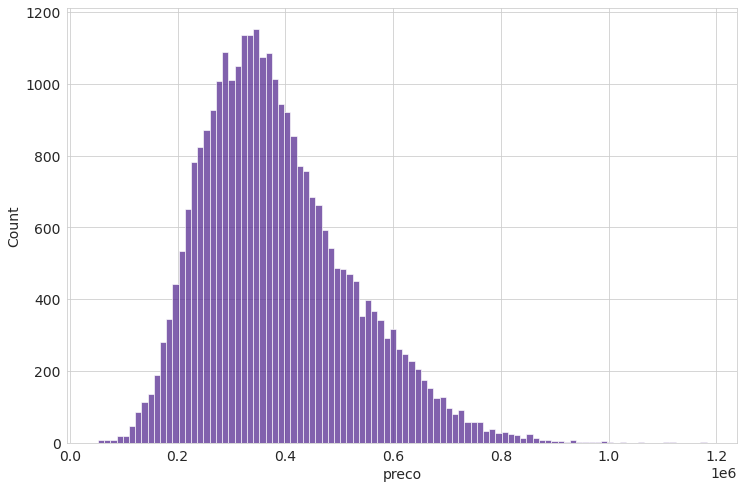

In [10]:
sns.histplot(apartamentos_df['preco'])

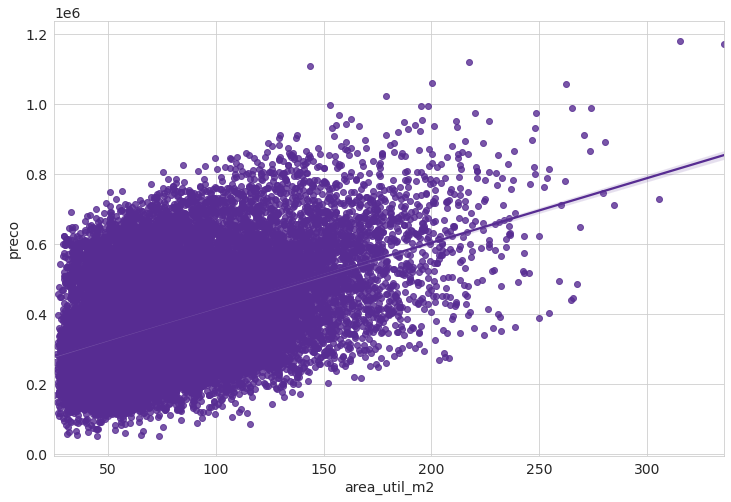

In [11]:
sns.regplot(data=apartamentos_df, x='area_util_m2', y='preco')

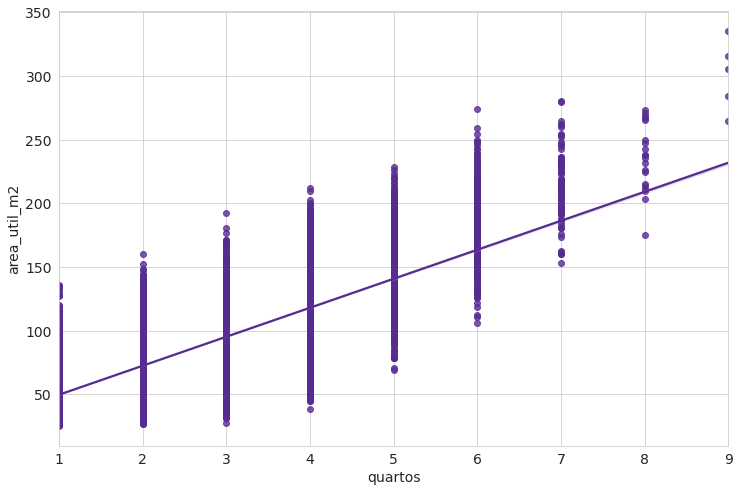

In [12]:
sns.regplot(data=apartamentos_df, x='quartos', y='area_util_m2')

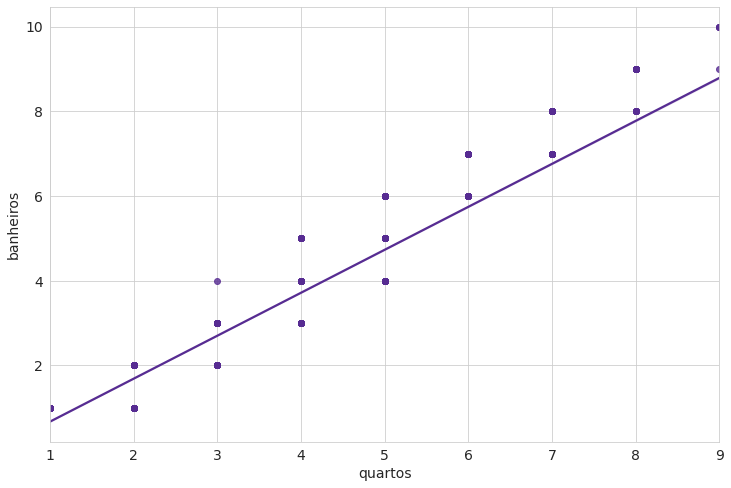

In [13]:
sns.regplot(data=apartamentos_df, x='quartos', y='banheiros')

### Explorando a variável `bairro`

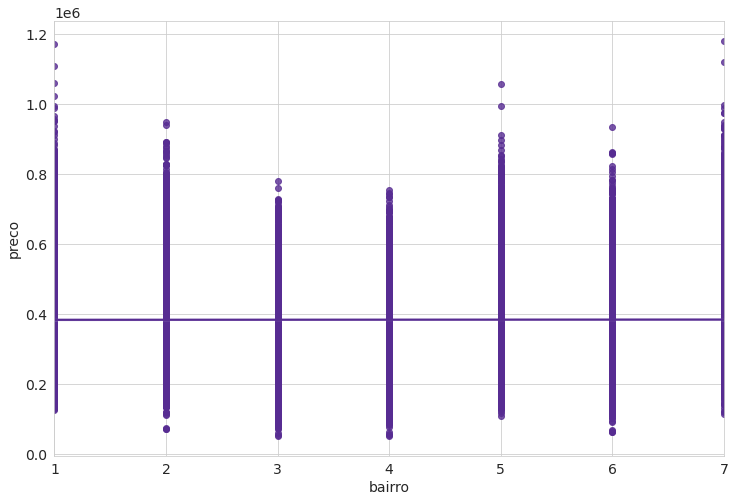

In [14]:
sns.regplot(data=apartamentos_df, x='bairro', y='preco')

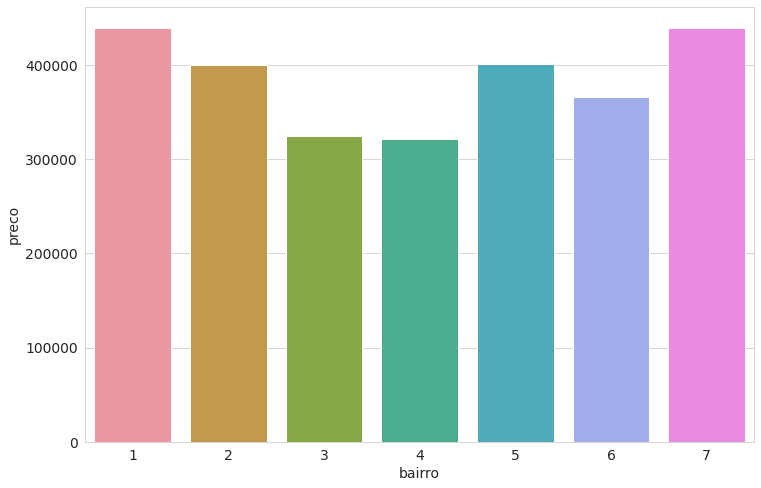

In [15]:
sns.barplot(data=apartamentos_df, x='bairro', y='preco', ci=None)

O fato de cada linha ter uma angulação diferente sugere que `preco` é uma função da interação entre `area_util_m2` e `bairro`.

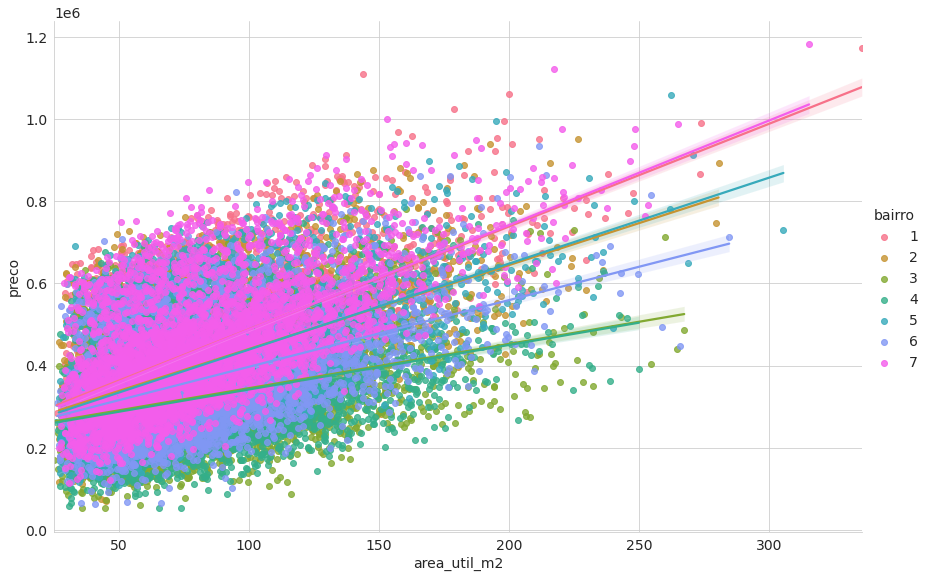

In [16]:
sns.lmplot(data=apartamentos_df, x='area_util_m2', y='preco', hue='bairro', height=8, aspect=12/8)

### Explorando a variável `lazer`

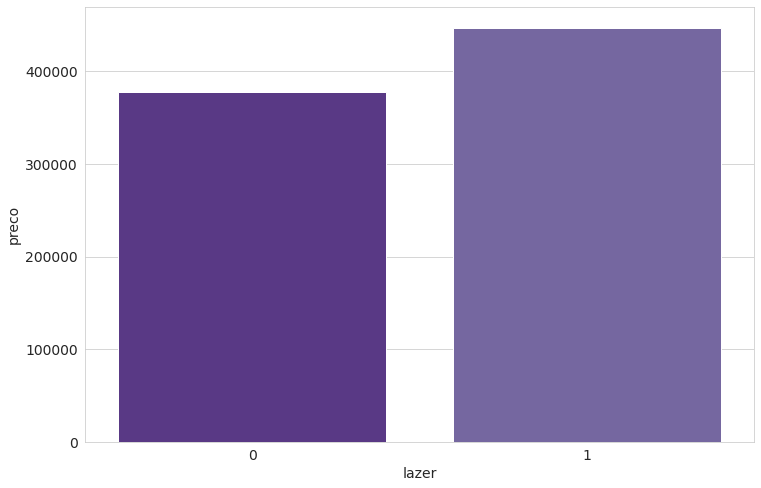

In [17]:
sns.barplot(data=apartamentos_df, x='lazer', y='preco', ci=None)

In [18]:
apartamentos_df.query('lazer == 1')['preco'].mean() - apartamentos_df.query('lazer == 0')['preco'].mean()

69493.68981945771

O fato das linhas serem paralelas sugere que `lazer` influencia no `preço`, mas não interage com `area_util_m2`.

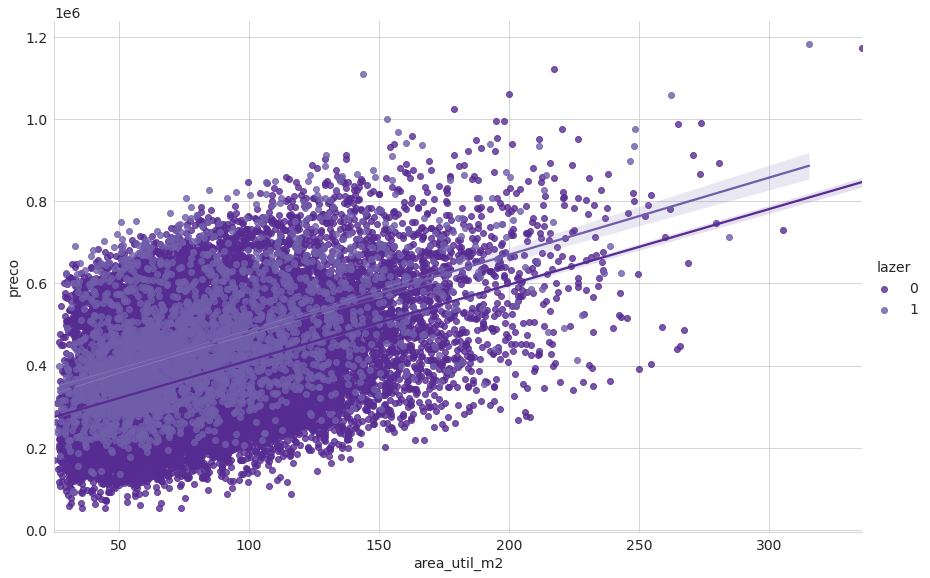

In [19]:
sns.lmplot(data=apartamentos_df, x='area_util_m2', y='preco', hue='lazer', height=8, aspect=12/8)

In [20]:
print(smf.ols(formula='preco ~ area_util_m2 + lazer', data=apartamentos_df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  preco   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     4801.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):               0.00
Time:                        21:27:59   Log-Likelihood:            -3.9322e+05
No. Observations:               30000   AIC:                         7.864e+05
Df Residuals:                   29997   BIC:                         7.865e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2.283e+05   1760.103    129.723   

### One hot encoding da variável `bairro`

Nesse exemplo usamos apenas a "maneira statsmodels" de fazer one hot encoding.

O primeiro modelo usa a variável `bairro` como uma variável categórica comum. Ou seja, assume que `bairro` influencia no preço do imóvel, mas não tem interação com `area_util_m2`

In [21]:
print(smf.ols(formula='preco ~ area_util_m2 + C(bairro)', data=apartamentos_df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  preco   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     2120.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):               0.00
Time:                        21:27:59   Log-Likelihood:            -3.9136e+05
No. Observations:               30000   AIC:                         7.827e+05
Df Residuals:                   29992   BIC:                         7.828e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.904e+05   2265.800    128.

Enquanto o segundo modelo usa a variável `bairro` como um termo de interação com `area_util_m2`, assumindo que existe de fato interação entre as duas variáveis. Ele efetivamente multiplica o que seria `bairro_2`, `bairro_3`, etc, com `area_util_m2`.

In [22]:
print(smf.ols(formula='preco ~ area_util_m2 + area_util_m2 : C(bairro)', data=apartamentos_df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  preco   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     2323.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):               0.00
Time:                        21:27:59   Log-Likelihood:            -3.9089e+05
No. Observations:               30000   AIC:                         7.818e+05
Df Residuals:                   29992   BIC:                         7.819e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

### Matriz de correlação

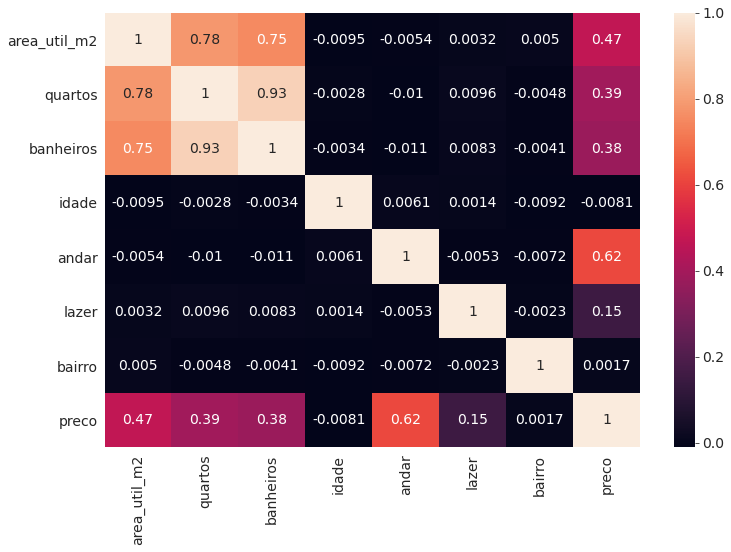

In [23]:
sns.heatmap(apartamentos_df.corr(), annot = True)

## Metricas

### MSE (mean squared error)

$ MSE = \frac{1}{n} \sum_{i=1}^{n}{(y_i - \hat{y}_1)^2} $

----
### RMSE (root mean squared error)

$ RMSE = \sqrt{MSE} $

----
### MAE (mean absolute error)

$ MAE = \frac{1}{n} \sum_{i=1}^{n}{|y_i - \hat{y}_1|} $

----
### R2 (R-squared)

$ R^2 = 1 - \frac{\text{Unexplained Variation}}{\text{Total Variation}} = 1 - \frac{RSS}{TSS}$

$ RSS = \sum_{i=1}^{n}{(y_i - \hat{y}_i)^2} $

$ TSS =  \sum_{i=1}^{n}{(y_i - \bar{y})^2} $

----
### Adjusted R2

$ R^2_{adj} = R^2 \frac{n - 1}{n - k - 1} $

$ n = \text{número de amostras} $

$ k = \text{número de variáveis preditoras} $

-----

Text(0.5, 1.0, 'MSE x RMSE')

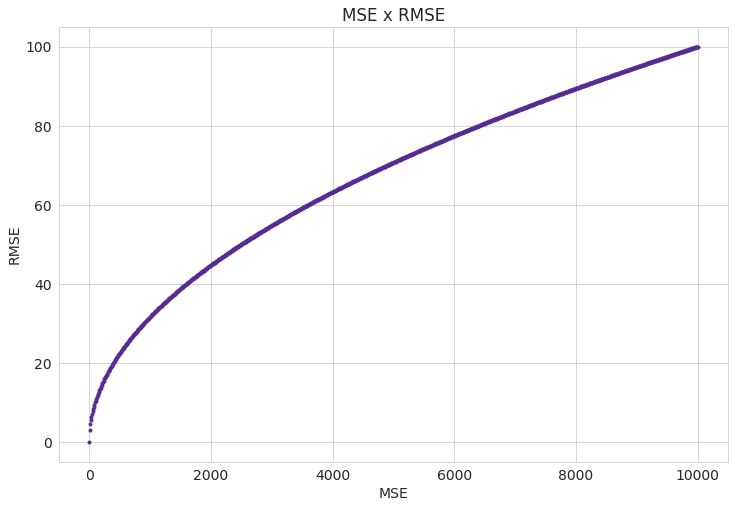

In [24]:
plt.plot(np.linspace(0, 10000, 1000), np.sqrt(np.linspace(0, 10000, 1000)), '.')
plt.xlabel('MSE')
plt.ylabel('RMSE')
plt.title('MSE x RMSE')

### Relações não-lineares

#### Exemplo polinômio

Nesse exemplo `y` varia em função de um polinômio de terceiro grau de `x`. Note como o modelo linear é incapaz de capturar essa relação.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


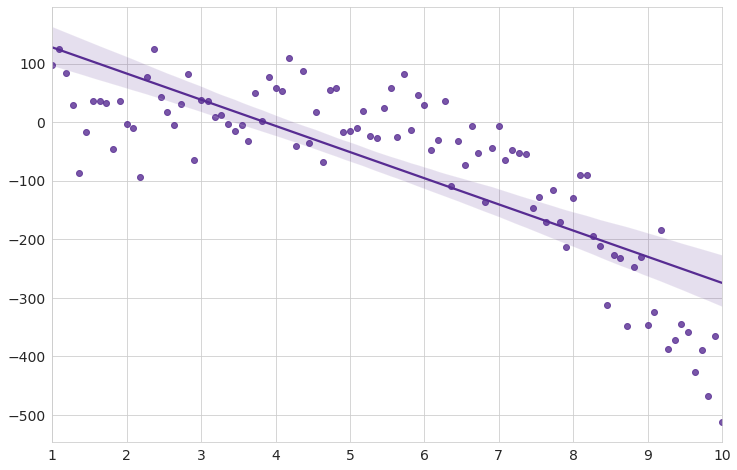

In [25]:
x = np.linspace(1, 10, 100)
y = 3*x + 5*x**2 - x**3 + np.random.normal(1, 50, 100)
sns.regplot(x, y)

Transformando a variável `x`, conseguimos fazer com que o modelo capture a relação corretamente.

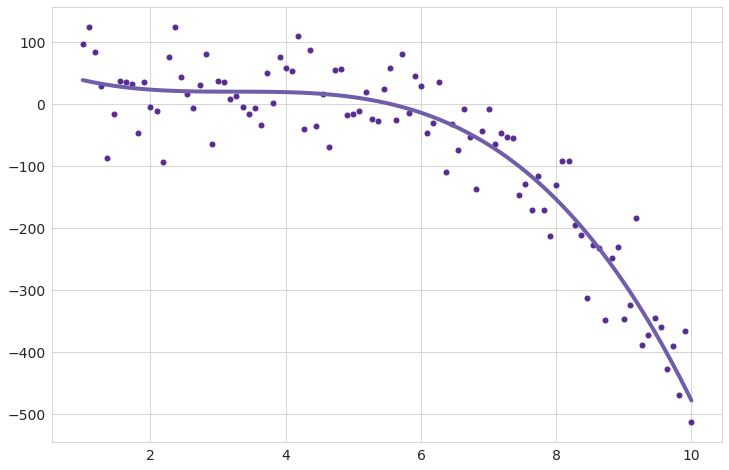

In [26]:
modelo_nao_linear = smf.ols("y ~ x + I(x**2) + I(x**3)", data=pd.DataFrame({'x': x, 'y': y})).fit()
y_hat = modelo_nao_linear.predict(pd.DataFrame({'x': x})).values
plt.plot(x, y, '.', markersize=10)
plt.plot(x, y_hat, '-', linewidth=4)

Não existe limite de complexidade para os modelos, porém geralmente quanto mais complexidade, mais longe ficamos da generalização do modelo. O modelo abaixo usa um polinômio de 5 graus e enxerga relações onde só há ruído.

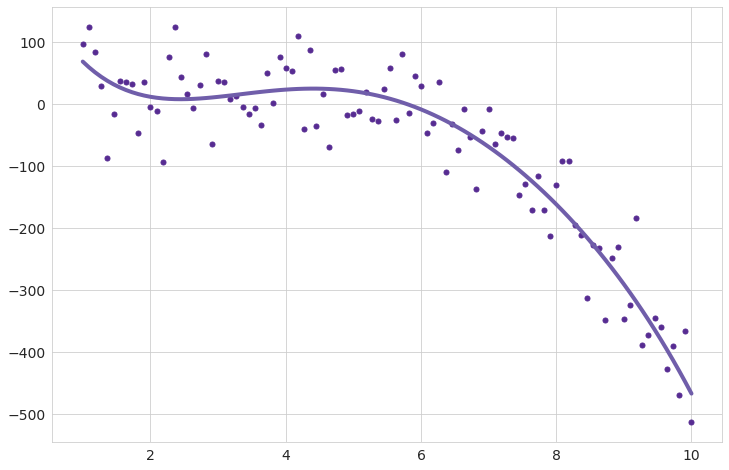

In [27]:
modelo_nao_linear = smf.ols("y ~ x + I(x**2) + I(x**3) + I(x**4) + I(x**5)", data=pd.DataFrame({'x': x, 'y': y})).fit()
y_hat = modelo_nao_linear.predict(pd.DataFrame({'x': x})).values
plt.plot(x, y, '.', markersize=10)
plt.plot(x, y_hat, '-', linewidth=4)

### Exemplo categórico

Nesse exemplo `y` varia em função de `x` de acordo com bandas arbitrárias (1-150, 150-500 e 500-1000).

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


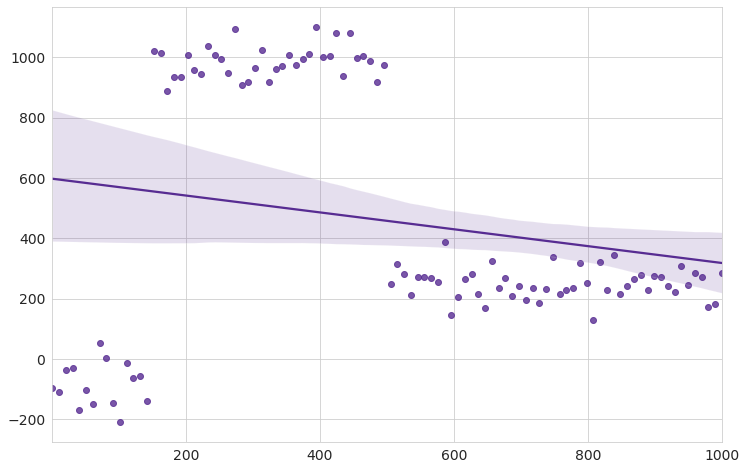

In [28]:
x = np.linspace(1, 1000, 100)
y = np.where(x < 150, -100, np.where(x < 500, 1000, 250)) + np.random.normal(0, 50, 100)
sns.regplot(x, y)

Note que comentamos a variável `maior_que_500` pois não precisamos dela, ela só introduziria colinearidade no modelo.

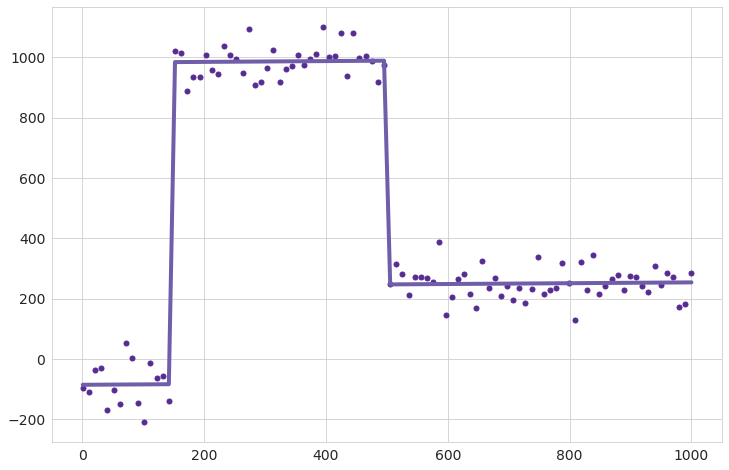

In [29]:
menor_que_150 = np.where(x < 150, 1, 0)
entre_150_500 = np.where((x >= 150) & (x < 500), 1, 0)
# maior_que_500 = np.where(x >= 500, 1, 0)

df = pd.DataFrame({
    'x': x,
    'menor_que_150': menor_que_150,
    'entre_150_500': entre_150_500,
    # 'maior_que_500': maior_que_500,
    'y': y
})

modelo_nao_linear_2 = smf.ols("y ~ x + menor_que_150 + entre_150_500 ", data=df).fit()
y_hat = modelo_nao_linear_2.predict(df[['x', 'menor_que_150', 'entre_150_500']]).values
plt.plot(x, y, '.', markersize=10)
plt.plot(x, y_hat, '-', linewidth=4)

## Preparando dados para o desafio

OBS: O desafio está presente no outro notebook, aqui só fazemos a separação entre treino e teste.

In [36]:
features = [
    'id', 'data', 'quartos', 'banheiros', 'area_util_m2',
    'area_total_m2', 'andares', 'orla_mar', 'nota_vista', 'nota_condicao',
    'nota', 'area_porao_m2', 'ano_construcao', 'ano_reforma', 'tem_porao',
    'teve_reforma'
]

target = 'preco_dolares'

X_train, X_test, y_train, y_test = train_test_split(
    imoveis_df[features], 
    imoveis_df[target], 
    test_size=1/4, 
    random_state=42
)

X_train[target] = y_train
X_test[target] = y_test

X_train.to_csv('dataset_imoveis_treino.csv', index=False)
X_test.to_csv('dataset_imoveis_teste.csv', index=False)